# Date: 12th June 2019

In [1]:
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [3]:
def makeJetImages(grid = 32, n_data = 10, n_particles = 5, isSignal = False):

    '''inputs: image size, number of datapoints, number of particles in each subjet, signal or background'''
    '''outputs: array of images, radii, theta, labels, summed image'''

    # origin
    center = int((grid-1)/2)
    
    # create input variables
    if isSignal:
        theta = np.random.normal(loc=0.2, scale=0.02, size=n_data) # signal_d
        z = np.random.normal(loc=0.5, scale=0.02, size=n_data) #signal_z 
        labels = np.ones(shape=(n_data,1))
    else:
        theta = np.random.exponential(scale=0.02, size=n_data) # bkg_d
        z = np.random.exponential(scale=0.02, size=n_data) #bkg_z
        labels = np.zeros(shape=(n_data,1))
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    z = np.repeat(z, n_particles).reshape(n_data, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_data, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_data), z)
    particles2 = np.multiply(partition_exp(n_particles, n_data), (1-z))
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_data,2))
    radii1 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    
    # position of particles on the grid : subscripts 1, 2 for particles in jet1, jet2 respectively   
    x1 = (np.multiply(dtheta1, np.cos(phi1))*grid).astype(int) + center
    x2 = (np.multiply(dtheta2, np.cos(phi2))*grid).astype(int) + center
    y1 = (np.multiply(dtheta1, np.sin(phi1))*grid).astype(int) + center
    y2 = ((np.multiply(dtheta2, np.sin(phi2))-theta)*grid).astype(int) + center

    ybins1 = np.arange(0,grid+1)
    xbins1 = np.arange(0,grid+1)
    
    # H1, H2 are the images from the first and second subjet respectively  
    H1_ = (np.vstack(np.array([(np.histogram2d( y1[i], x1[i], bins=(xbins1, ybins1), weights = particles1[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H2_ = (np.vstack(np.array([(np.histogram2d( y2[i], x2[i], bins=(xbins1, ybins1), weights = particles2[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H_ = (H1_+H2_) # images witb both subjets
    # performing a parity flip so that the right side of the jet image has the highest sum pixel intensity
    H_parity = np.sum(H_, axis=1)
    if (grid%2==0):
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center+1], axis=1), grid**2).reshape(n_data,grid,grid)
    else:
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center], axis=1), grid**2).reshape(n_data,grid,grid)
    H_right_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,center+1:], axis=1), grid**2).reshape(n_data,grid,grid)
    images = np.where(H_right_>H_left_, H_, np.flip(H_, axis=2))
    avgImages = np.sum(images, axis =0)
    theta = theta.reshape(n_data*n_particles,1)[::n_particles]

    return images, radii, theta, labels, avgImages

In [4]:
grid = 32
n_data = 10000
n_particles = 10

## 'Signal' jet images and their plots

In [5]:
tic = time.perf_counter()
isSignal1 = True
images1, radii1, theta1, labels1, avgImages1 = makeJetImages(grid, n_data, n_particles, isSignal1)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('jetImages_signal', jetImages = images1, radiilab = radii1, thetalab = theta1, labels = labels1, sumedImage = avgImages1)

Processing Time is  2.2673761999994895 seconds for  10000  samples.


#### Average signal image - log scale norm

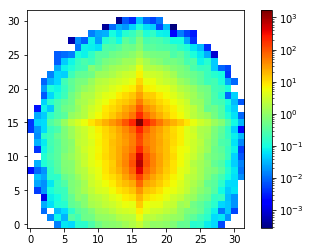

In [6]:
im1 = plt.imshow(avgImages1, interpolation='nearest', origin='low', norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.show()

#### Individual 'signal' jet images

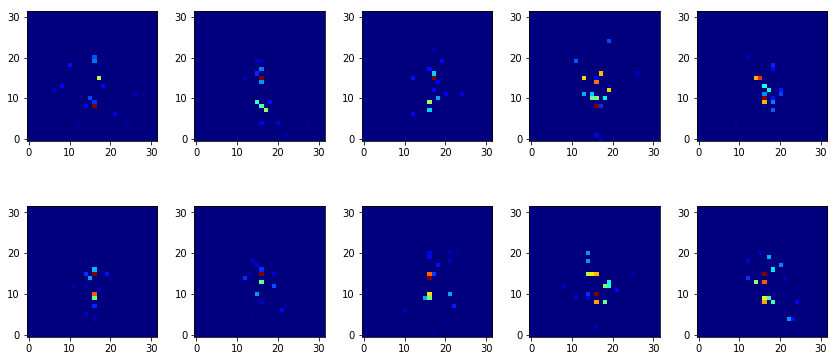

In [7]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images1[i], interpolation='nearest', origin='low', cmap='jet')

## 'Background' jet images and their plots

In [8]:
tic = time.perf_counter()
isSignal2 = False
images2, radii2, theta2, labels2, avgImages2 = makeJetImages(grid, n_data, n_particles, isSignal2)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('jetImages_bkg', jetImages = images2, radiilab = radii2, thetalab = theta2, labels = labels2, sumedImage = avgImages2)

Processing Time is  2.2803327999999965 seconds for  10000  samples.


#### Average background image - log scale norm

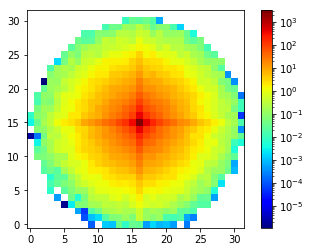

In [9]:
im1 = plt.imshow(avgImages2, interpolation='nearest', origin='low', norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.show()

#### Individual 'background' jet images

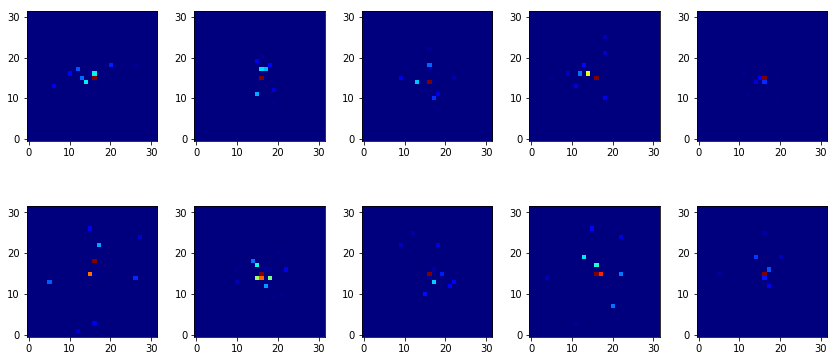

In [10]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images2[i], interpolation='nearest', origin='low', cmap='jet')